# 時系列データ処理 (ACF, PACF, SARIMAモデル)

@sinhrks さんによるPyCon JPの発表「pandas による時系列データ処理」が面白そうだったので、一通り動かしてみる。
今回は時系列データとしてKaggleのコンテスト用にで公開されたBitcoinのデータを対象にする。結果的に取引に有用そうな意味のある傾向はとれなかったが、記録として残しておく。

* [PyConJP 2016: pandas による 時系列データ処理 by Sinhrks](https://speakerdeck.com/sinhrks/pyconjp-2016-pandas-niyoru-shi-xi-lie-detachu-li)
* [Bitcoin Historical Data Bitcoin data at 1-min intervals from select exchanges, Jan 2012 to March 2018 - CC BY SA 4.0](https://www.kaggle.com/mczielinski/bitcoin-historical-data)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('./data/bitstampUSD_1-min_data_2012-01-01_to_2017-10-20.csv')

In [3]:
df.index = pd.to_datetime(df['Timestamp'], unit='s')
df.index = df.index.tz_localize('UTC').tz_convert('Asia/Tokyo')

In [4]:
df = df['2016-11':'2017-11']

In [5]:
df.loc[(df.index.year == 2017) & (df.index.month == 10)].loc[:,['Open', 'High', 'Low', 'Close']].describe()

,Open,High,Low,Close
count,27901.000000,27901.000000,27901.000000,27901.000000
mean,4900.136955,4902.818713,4896.675484,4900.031256
std,578.790023,579.605510,577.727258,578.721020
min,4137.960000,4141.750000,4137.960000,4137.960000
25%,4343.970000,4344.990000,4341.680000,4343.990000
50%,4769.000000,4771.310000,4765.260000,4768.600000
75%,5581.040000,5585.710000,5576.070000,5581.010000
max,5846.430000,5846.430000,5839.640000,5844.400000


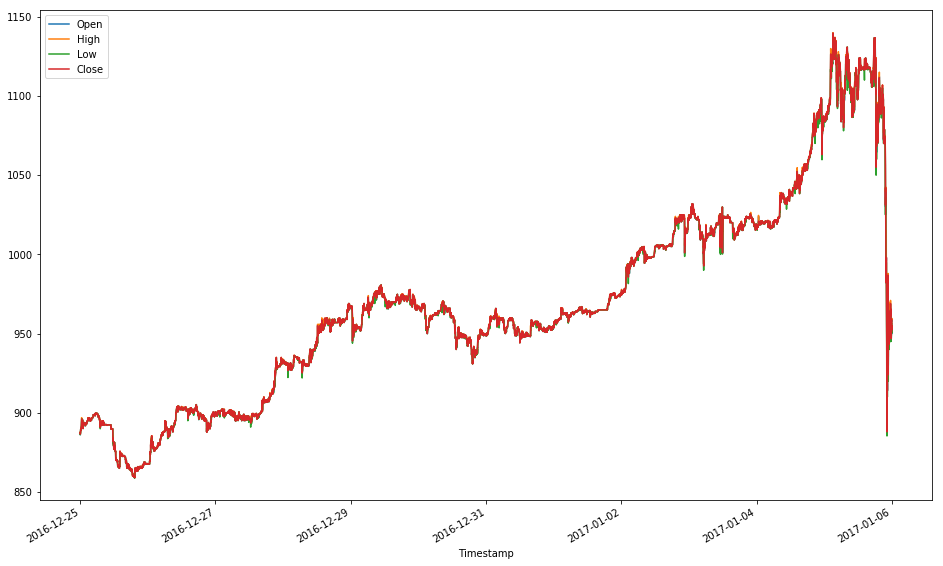

In [6]:
df['2016-12-25':'2017-01-05'].loc[:,['Open', 'High', 'Low', 'Close']].plot(figsize=(16, 10))

In [ ]:
df['2016-12-25':'2017-01-05'].loc[:,['Open', 'High', 'Low', 'Close']].plot(figsize=(16, 10))

# 時系列の成分分解

In [7]:
df['time'] = pd.to_datetime(df['Timestamp'], unit='s')
df_per_day = pd.pivot_table(df, index=pd.Grouper(key='time', freq='D'), values='Open', aggfunc='mean')

In [8]:
df_per_day.count()

Open    355
dtype: int64

In [9]:
df_per_day.index

DatetimeIndex(['2016-10-31', '2016-11-01', '2016-11-02', '2016-11-03',
               '2016-11-04', '2016-11-05', '2016-11-06', '2016-11-07',
               '2016-11-08', '2016-11-09',
               ...
               '2017-10-11', '2017-10-12', '2017-10-13', '2017-10-14',
               '2017-10-15', '2017-10-16', '2017-10-17', '2017-10-18',
               '2017-10-19', '2017-10-20'],
              dtype='datetime64[ns]', name='time', length=355, freq='D')

In [10]:
df_per_day = df_per_day.dropna()
df_per_day = df_per_day.resample('D').ffill()

/Users/c-bata/src/github.com/c-bata/pytrader/venv/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


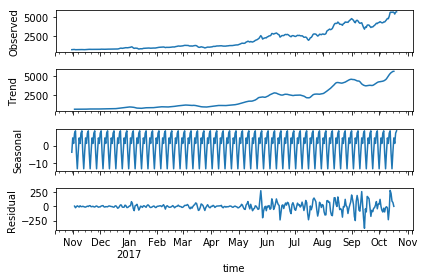

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(df_per_day)
fig = res.plot()

上から、元データ、トレンド、季節性、残差

# 時系列固有の統計量

よく使われるものはACFとPACF。1つ自分とずらした場合の相関とかを表す。

* 標本自己相関(ACF)
* 標本偏自己相関 (PACF)

/Users/c-bata/src/github.com/c-bata/pytrader/venv/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


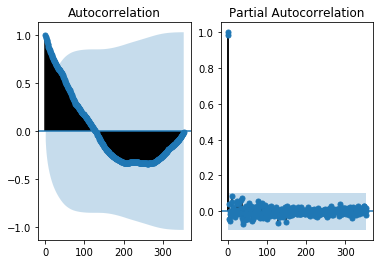

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2)
plot_acf(df_per_day, ax=axes[0])
plot_pacf(df_per_day, ax=axes[1])
fig.show()

1つ前からどれくらい影響を受けてるか、2つ前からどれくらい影響を受けてるかを指している。
例えば 横軸が0 のときは、自分自身なので、必ず1になる。

相関がない場合(ホワイトノイズ)は次のようになる。

/Users/c-bata/src/github.com/c-bata/pytrader/venv/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


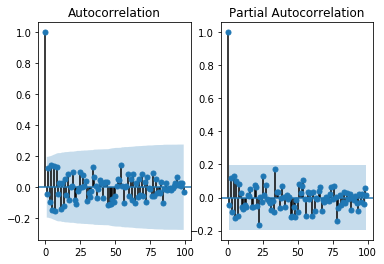

In [18]:
wn = pd.Series(np.random.randn(100))
fig, axes = plt.subplots(1, 2)
plot_acf(wn, ax=axes[0])
plot_pacf(wn, ax=axes[1])
fig.show()

Bitcoinの場合は、急激な変化がそれほど置きないので、相関があるのは当たり前。この指標は参考にならない。

# SARIMAモデル (季節的自己回帰和分移動平均モデル)

* 自己回帰和分移動平均モデル (ARIMA)
* + 季節変動 (ARIMA)

裏側では2つの同じモデル(ARIMA)を移動平均と季節変動に適用した。
差分をとっていくと何か上手い条件に引っかかって、詳細は省くけどちょっとややこしい式にモデル化できる。

平均とか自己共分散が時間によらず一定であるという条件が必要。
トレンドがある場合には、除去しないといけない。

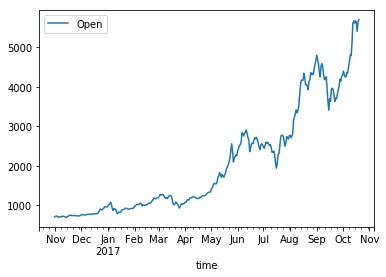

In [31]:
df_per_day.plot()

階差(1個前との差分)を計算してみる

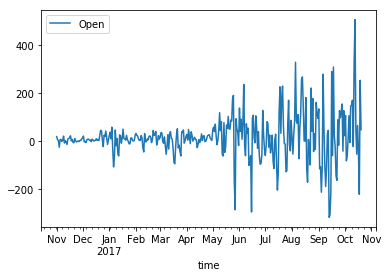

In [32]:
df_per_day.diff().plot()

分散が時間によって大きい。当たり前といえば当たり前だけど誤差がある。
対数変換してみる。

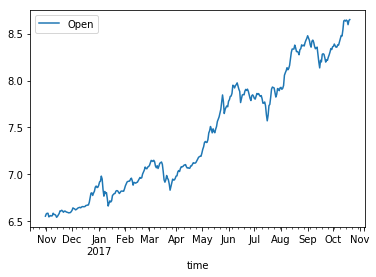

In [33]:
ldf = np.log(df_per_day)
ldf.plot()

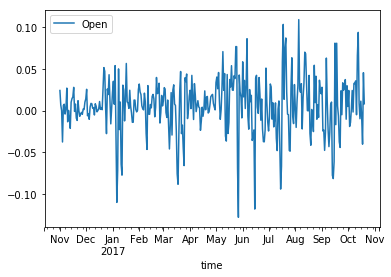

In [34]:
ldf.diff().plot()

トレンドが消えた

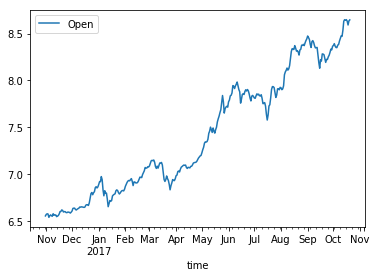

In [37]:
res = seasonal_decompose(ldf)
seasonal_adjust = (ldf - res.seasonal)  # 季節成分を引く
seasonal_adjust.plot()

## 単位根検定による弱定常の検証

定常(弱定常)を満たしてるかどうか。値が少ないほどいい。

In [46]:
from statsmodels.tsa.stattools import adfuller

print("元データ", adfuller(df_per_day['Open'])[1])
print("対数化", adfuller(ldf['Open'])[1])
print("対数化 + 階差", adfuller(ldf['Open'].diff().dropna())[1])
print("対数化 + 季節性除去 + 階差", adfuller(seasonal_adjust['Open'].diff().dropna())[1])

元データ 0.996467210595
対数化 0.975597426655
対数化 + 階差 2.84010306011e-24
対数化 + 季節性除去 + 階差 4.46528035878e-24


季節性は無いのかもしれない。周期も1年だし、Bitcoinにそもそも季節性とかないか。
対数化 + 階差をとれば十分に弱定常

In [48]:
from statsmodels.tsa.statespace import sarimax

# SARIMAXモデルを使えば簡単にモデルが出来る。
# 対数化したデータフレーム
mod_seasonal = sarimax.SARIMAX(ldf, trend='c', order=(1, 1, 1), seasonal_order=(0, 1, 2, 12))
res_seasonal = mod_seasonal.fit()  # フィッティング
res_seasonal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                               Open   No. Observations:                  355
Model:             SARIMAX(1, 1, 1)x(0, 1, 2, 12)   Log Likelihood                 682.433
Date:                            Sun, 31 Dec 2017   AIC                          -1352.866
Time:                                    04:43:04   BIC                          -1329.634
Sample:                                10-31-2016   HQIC                         -1343.624
                                     - 10-20-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.000      0.714      0.475      -0.000       0.001
ar.L1          0.0092      0.123      0.075      0.941      -0.233       0.251
ma.L1          0.3555      0.122      2.905      0.004       0.116       0.595
ma.S.L12      -0.9239      0.061    -15.067      0.000      -1.044      -0.804
ma.S.L24      -0.0162      0.060     -0.268      0.789      -0.134       0.102
sigma2         0.0010   6.77e-05     14.846      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                       43.99   Jarque-Bera (JB):                17.41
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               2.32   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

モデルからの予測

In [50]:
pred= res_seasonal.forecast(36)  # 36期先を予測
pred

2017-10-21    8.648405
2017-10-22    8.666043
2017-10-23    8.674310
2017-10-24    8.704003
2017-10-25    8.718431
2017-10-26    8.726027
2017-10-27    8.725210
2017-10-28    8.741189
2017-10-29    8.747978
2017-10-30    8.743772
2017-10-31    8.753976
2017-11-01    8.755362
2017-11-02    8.759021
2017-11-03    8.776585
2017-11-04    8.785280
2017-11-05    8.814535
2017-11-06    8.827769
2017-11-07    8.835554
2017-11-08    8.835090
2017-11-09    8.851343
2017-11-10    8.858597
2017-11-11    8.855234
2017-11-12    8.865017
2017-11-13    8.866494
2017-11-14    8.870421
2017-11-15    8.888189
2017-11-16    8.897087
2017-11-17    8.926546
2017-11-18    8.939982
2017-11-19    8.947970
2017-11-20    8.947709
2017-11-21    8.964165
2017-11-22    8.971622
2017-11-23    8.968462
2017-11-24    8.978448
2017-11-25    8.980128
Freq: D, dtype: float64

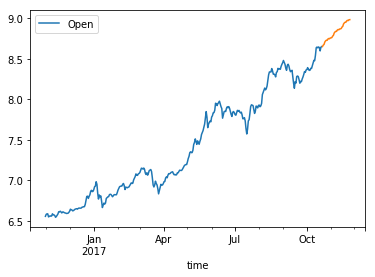

In [51]:
ax = ldf.plot()
pred.plot(ax=ax)

まぁこう右肩上がりにはなるだろうけど、読めてる気がしないな。。。
もっと短期間のデータから直近を読ませるか